# Power-Law Patterns in Sentence Context Vector Clustering (Wiki Sentences)


**Dataset Used:**
- [Wikipedia Sentences](https://www.kaggle.com/datasets/mikeortman/wikipedia-sentences) (Kaggle)


Corpus Size: Middle 2000 sentences extracted


# Outline:

1. Collects a large continous text (3000 sentences)
2. Computes each sentence’s embedding with [StoryEmb model](https://huggingface.co/uhhlt/story-emb) (built onMistral), all-mpnet-base-v2 (sentence-transformer), all-distilroberta-v1 (sentence-transformer).
4. Calculates pairwise cosine similarities between the embeddings.
5. Assumes the similarity of 0.90 and above as similar sentences. Counts the number of the similar sentences. Adds the number of words on each group as a sanity check.
6. Stores the group counts in a vector, rearrange it, and plot count (y-axis) versus matrix index (x-axis).
7. Plots the log log plot using the count matrix.

# Data Load

In [2]:
import nltk
import json

nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize

corpus_path = "/content/wikisent.txt"
with open(corpus_path, 'r', encoding='utf-8') as file:
    corpus_text = file.read()

sentences = sent_tokenize(corpus_text)
print(f"Total number of sentences: {len(sentences)}")

num_sentences_to_extract = 3000

if len(sentences) > num_sentences_to_extract:
    mid_index = len(sentences) // 2
    half_window = num_sentences_to_extract // 2
    # extract the middle 2000 sentences
    sentences = sentences[mid_index - half_window : mid_index + half_window]

with open("book_sentences.json", "w", encoding="utf-8") as f:
    json.dump(sentences, f)

print(f"Saved extracted middle {len(sentences)} sentences as 'book_sentences.json'.")
print(f"Final number of sentences: {len(sentences)}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Total number of sentences: 26710
Saved extracted middle 3000 sentences as 'book_sentences.json'.
Final number of sentences: 3000


In [3]:
import json

output_path = "/content/wiki_3000_sentences.json"

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(sentences, f, ensure_ascii=False, indent=4)

print(f"saved {len(sentences)} sentences to {output_path}")

saved 3000 sentences to /content/wiki_3000_sentences.json


# Load LLM models & Compute Embedding Vectors

In [4]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [5]:
# model 1: load StoryEmb model (transformers-based)
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np

# load StoryEmb model
model_name = "uhhlt/story-emb"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model1 = AutoModel.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

def get_embedding1(model, tokenizer, sentences, batch_size=16):
  embeddings = []

  # batch processing
  for i in range(0, len(sentences), batch_size):
    batch = sentences[i:i+batch_size]
    inputs = tokenizer(
      batch,
      padding=True,
      truncation=True,
      max_length=256,
      return_tensors="pt"
    ).to(model.device)

    with torch.no_grad():
      outputs = model(**inputs)

    batch_embeddings = outputs.last_hidden_state[:, 0, :]
    embeddings.append(batch_embeddings.cpu())

  return torch.cat(embeddings, dim=0).numpy()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/669 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
# initialize models 2 & 3
from sentence_transformers import SentenceTransformer
# model 2: all-mpnet-base-v2
model2 = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
# model 3: all-distilroberta-v1
model3 = SentenceTransformer('sentence-transformers/all-distilroberta-v1')

def get_embedding2(model, sentences):
  embeddings = model.encode(sentences)
  return embeddings



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
# get embeddings StoryEmb
embeddings1 = get_embedding1(model1, tokenizer, sentences, batch_size=16)
print("StoryEmb Embeddings Shape:", embeddings1.shape)

StoryEmb Embeddings Shape: (3000, 4096)


In [8]:
# get embeddings all-mpnet-base-v2
embeddings2 = get_embedding2(model2, sentences)
print("all-mpnet-base-v2 Embeddings Shape:", embeddings2.shape)

all-mpnet-base-v2 Embeddings Shape: (3000, 768)


In [9]:
# get embeddings all-distilroberta-v1
embeddings3 = get_embedding2(model3, sentences)
print("all-distilroberta-v1 Embeddings Shape:", embeddings3.shape)

all-distilroberta-v1 Embeddings Shape: (3000, 768)


### Compute the inter vector Cosine similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cos_similar1 = cosine_similarity(embeddings1)
cos_similar2 = cosine_similarity(embeddings2)
cos_similar3 = cosine_similarity(embeddings3)

In [ ]:
print("storyemb Cosine Similarity")
print(np.round(cos_similar1[:5, :5], 2))

storyemb Cosine Similarity
[[1.   0.63 0.65 0.64 0.65]
 [0.63 1.   0.8  0.77 0.75]
 [0.65 0.8  1.   0.77 0.79]
 [0.64 0.77 0.77 1.   0.78]
 [0.65 0.75 0.79 0.78 1.  ]]


In [ ]:
print("all-mpnet-base-v2 Cosine Similarity")
print(np.round(cos_similar2[:5, :5], 2))

all-mpnet-base-v2 Cosine Similarity
[[ 1.    0.08  0.11  0.07 -0.09]
 [ 0.08  1.    0.41  0.31  0.27]
 [ 0.11  0.41  1.    0.2   0.28]
 [ 0.07  0.31  0.2   1.    0.3 ]
 [-0.09  0.27  0.28  0.3   1.  ]]


In [ ]:
print("all-distilroberta-v1 Cosine Similarity")
print(np.round(cos_similar3[:5, :5], 2))

all-distilroberta-v1 Cosine Similarity
[[ 1.    0.05  0.1   0.03 -0.02]
 [ 0.05  1.    0.58  0.31  0.31]
 [ 0.1   0.58  1.    0.17  0.37]
 [ 0.03  0.31  0.17  1.    0.31]
 [-0.02  0.31  0.37  0.31  1.  ]]


## Grouping and Clustering
- Now assuming the similarity of ex) 0.9 and above as similar sentences, count the number of these similar sentences. Alert, since counting can occur in different ways, do not count a particular sentence more than once. Add the number of words on each group as a sanity check.

# K Means Clustering

In [19]:
pip install kneed

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator
import random
from sklearn.preprocessing import normalize

In [21]:
norm_embedding1 = normalize(embeddings1, norm='l2')
norm_embedding2 = normalize(embeddings2, norm='l2')
norm_embedding3 = normalize(embeddings3, norm='l2')

### K Means Knee point locator

In [22]:
def find_optimal_k(embeddings, k_samples=None, k_min=5, k_max=50, k_step=None, random_sampling=False, plot=True):
    # random sampling or sequential?
    if random_sampling:
        random.seed(42)
        K = sorted(random.sample(range(k_min, k_max + 1), k_samples))
    else:
        K = list(range(k_min, k_max + 1, k_step if k_step else 1))

    # calculate WCSS for each k value
    wcss = []
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(embeddings)
        wcss.append(kmeans.inertia_)

    # find the knee point using KneeLocator
    knee = KneeLocator(K, wcss, curve='convex', direction='decreasing')
    optimal_k = knee.knee

    # plot the results if plot=True
    if plot and optimal_k:
        plt.figure(figsize=(8, 5))
        plt.plot(K, wcss, 'bo-', label='WCSS')
        plt.axvline(optimal_k, color='red', linestyle='--', label=f'Knee at k={optimal_k}')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('WCSS (Inertia)')
        plt.title('Elbow Method for Optimal k')
        plt.legend()
        plt.grid(True)
        plt.show()

    return optimal_k

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (55). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (105). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (155). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (205). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/b

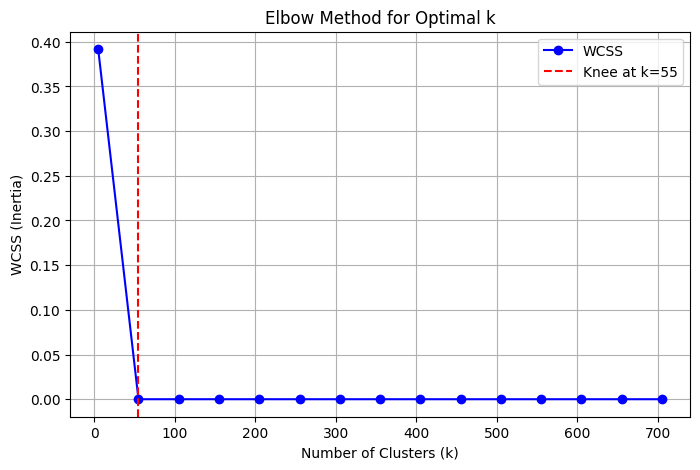

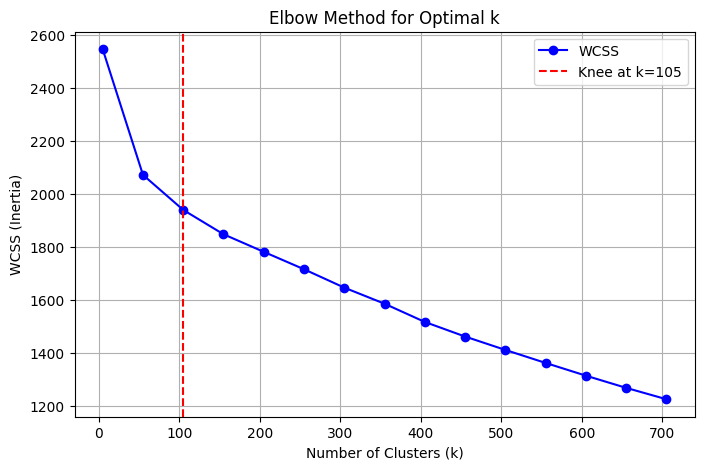

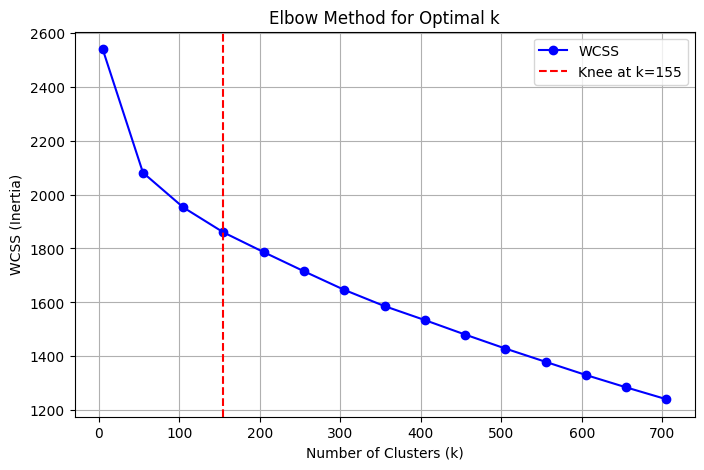

In [ ]:
# find optimal number of clusters for each embedding
optimal_k1 = find_optimal_k(norm_embedding1, k_min=5, k_max=705, k_step=50)
optimal_k2 = find_optimal_k(norm_embedding2, k_min=5, k_max=705, k_step=50)
optimal_k3 = find_optimal_k(norm_embedding3, k_min=5, k_max=705, k_step=50)

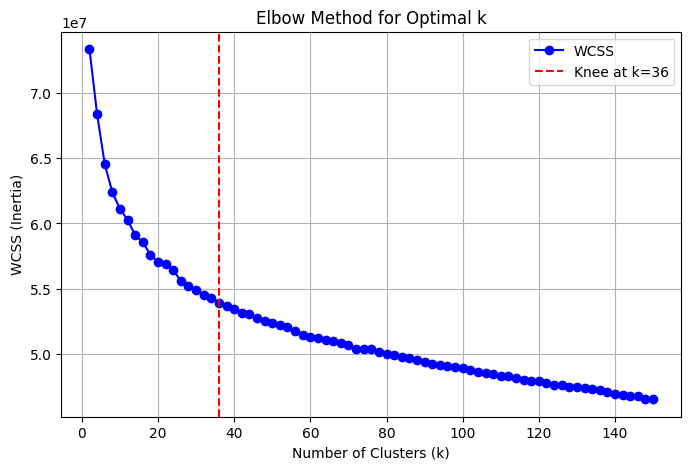

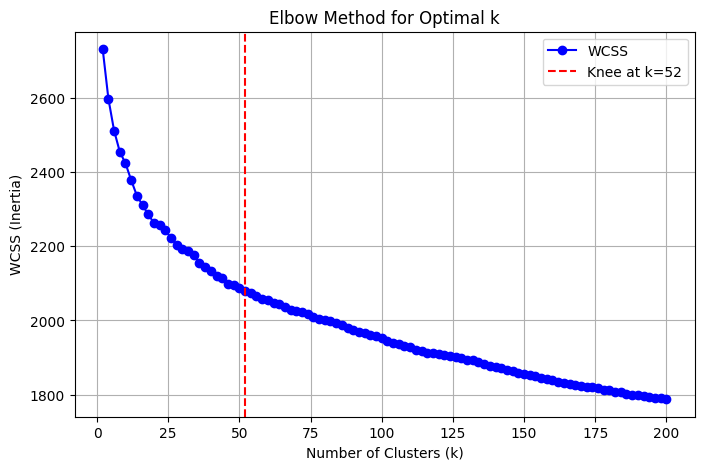

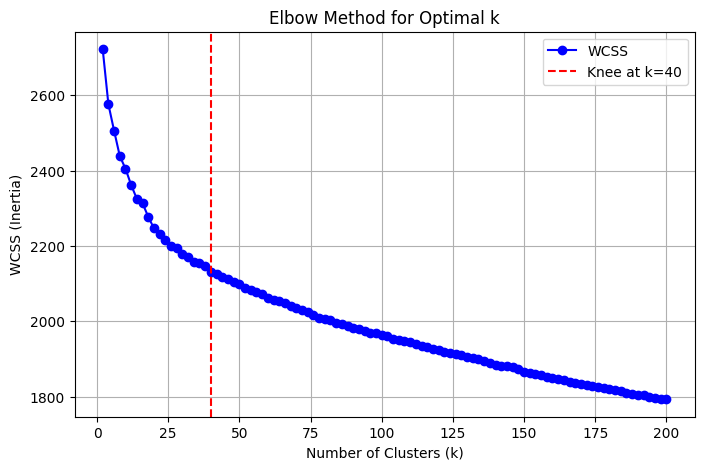

In [ ]:
# find optimal number of clusters for each embedding
optimal_k1 = find_optimal_k(embeddings1, k_min=2, k_max=150, k_step=2)
optimal_k2 = find_optimal_k(embeddings2, k_min=2, k_max=200, k_step=2)
optimal_k3 = find_optimal_k(embeddings3, k_min=2, k_max=200, k_step=2)

In [ ]:
# Apply KMeans with the optimal number of clusters
kmeans1 = KMeans(n_clusters=36, random_state=42)
kmeans2 = KMeans(n_clusters=52, random_state=42)
kmeans3 = KMeans(n_clusters=40, random_state=42)

cluster_labels1 = kmeans1.fit_predict(norm_embedding1)
cluster_labels2 = kmeans2.fit_predict(norm_embedding2)
cluster_labels3 = kmeans3.fit_predict(norm_embedding3)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (36). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


## K Means Sentence and word counts

In [ ]:
from nltk.tokenize import word_tokenize

def count_words_per_cluster(sentences, cluster_labels):
    # group sentences by cluster
    clusters = {}
    for idx, label in enumerate(cluster_labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(sentences[idx])

    # count total words per cluster
    word_counts_per_cluster = {}
    for label, cluster_sentences in clusters.items():
        word_count = 0
        for sentence in cluster_sentences:
            word_count += len(word_tokenize(sentence.lower()))
        word_counts_per_cluster[label] = word_count

    return sorted(word_counts_per_cluster.values(), reverse=True)


def count_sentences_per_cluster(cluster_labels):
    unique, counts = np.unique(cluster_labels, return_counts=True)
    return counts


words_per_cluster1 = count_words_per_cluster(sentences, cluster_labels1)
words_per_cluster2 = count_words_per_cluster(sentences, cluster_labels2)
words_per_cluster3 = count_words_per_cluster(sentences, cluster_labels3)

sentences_per_cluster1 = count_sentences_per_cluster(cluster_labels1)
sentences_per_cluster2 = count_sentences_per_cluster(cluster_labels2)
sentences_per_cluster3 = count_sentences_per_cluster(cluster_labels3)

vector_sent_kmeans1 = np.array(sorted(sentences_per_cluster1, reverse=True))
vector_sent_kmeans2 = np.array(sorted(sentences_per_cluster2, reverse=True))
vector_sent_kmeans3 = np.array(sorted(sentences_per_cluster3, reverse=True))


print("Embedding 1:")
print("\nSentence counts per cluster in Kmeans1:", vector_sent_kmeans1[:10])
print("\nWord counts per cluster in Kmeans1:", words_per_cluster1[:5])
print ("-------------------")
print("Embedding 2:")
print("\nSentence counts per cluster in Kmeans2:", vector_sent_kmeans2[:5])
print("\nWord counts per cluster in Kmeans2:", words_per_cluster2[:5])
print ("-------------------")
print("Embedding 3:")
print("\nSentence counts per cluster in Kmeans3:", vector_sent_kmeans3[:5])
print("\nWord counts per cluster in Kmeans3:", words_per_cluster3[:5])


Embedding 1:

Sentence counts per cluster in Kmeans1: [2994    1    1    1    1    1    1]

Word counts per cluster in Kmeans1: [69994, 12, 11, 10, 9]
-------------------
Embedding 2:

Sentence counts per cluster in Kmeans2: [129 113  98  97  97]

Word counts per cluster in Kmeans2: [3169, 2508, 2422, 2313, 2276]
-------------------
Embedding 3:

Sentence counts per cluster in Kmeans3: [173 133 109 100  97]

Word counts per cluster in Kmeans3: [3638, 3394, 2855, 2710, 2309]


# HDBSCAN Clustering

In [11]:
pip install hdbscan umap-learn

In [ ]:
n = len(sentences)

In [12]:
import random
from functools import partial
import hdbscan
import umap
import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm.notebook import trange
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

def hdbscan_clusters(message_embeddings,
                      n_neighbors,
                      n_components,
                      min_samples = None,
                      random_state = None):

    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors,
                                n_components = n_components,
                                metric = 'cosine',
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = 2,
                               min_samples = min_samples,
                               metric='euclidean',
                               gen_min_span_tree=True,
                               cluster_selection_method='eom').fit(umap_embeddings)

    return clusters

In [13]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 29.2 MB/s eta 0:00:00


###HDBSCAN UMAP hyperparameter tuning using Optuna

In [14]:
# tune UMAP hyper-parameters using Optuna
# Optuna runs one trial per grid point
import optuna
import umap
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score
from functools import partial
from sklearn.preprocessing import normalize



MIN_CLUSTER_SIZE = 2
MIN_SAMPLES      = None

def objective(trial, data):
    n_components = trial.suggest_int("n_components", 10, 40, step=5)
    n_neighbors  = trial.suggest_int("n_neighbors",  10, 40, step=5)

    reducer   = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        random_state=42,
        metric="euclidean",
        low_memory=True,
    )
    embedding = reducer.fit_transform(data)

    labels = HDBSCAN(
        min_cluster_size=MIN_CLUSTER_SIZE,

        **({} if MIN_SAMPLES is None else {"min_samples": MIN_SAMPLES})
    ).fit_predict(embedding)

    return silhouette_score(embedding, labels) if len(set(labels)) > 1 else -1

search_space = {
    "n_components": list(range(10, 41, 5)),
    "n_neighbors" : list(range(10, 41, 5)),
}

In [15]:
def tune_umap(data):
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.GridSampler(search_space),
    )
    study.optimize(partial(objective, data=data))
    return study

In [ ]:
embeddings1_study = tune_umap(norm_embedding1)
print("embeddings1 best score :", embeddings1_study.best_value)
print("embeddings1 best params:", embeddings1_study.best_params)

[I 2025-05-12 16:16:44,820] A new study created in memory with name: no-name-8f0845b7-20a0-4463-bdba-d931a7d8197a
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-12 16:18:02,051] Trial 0 finished with value: -0.3656582832336426 and parameters: {'n_components': 30, 'n_neighbors': 15}. B

embeddings1 best score : 0.6522059440612793
embeddings1 best params: {'n_components': 10, 'n_neighbors': 30}


In [ ]:
embeddings2_study = tune_umap(norm_embedding2)
print("embeddings2 best score :", embeddings2_study.best_value)
print("embeddings2 best params:", embeddings2_study.best_params)

[I 2025-05-12 17:33:20,178] A new study created in memory with name: no-name-09d1fdd1-7b99-47fd-80c0-6d3613f33774
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-12 17:33:41,583] Trial 0 finished with value: 0.1323469877243042 and parameters: {'n_components': 30, 'n_neighbors': 15}. Be

embeddings2 best score : 0.2056107521057129
embeddings2 best params: {'n_components': 20, 'n_neighbors': 10}


In [ ]:
embeddings3_study = tune_umap(norm_embedding3)
print("embeddings3 best score :", embeddings3_study.best_value)
print("embeddings3 best params:", embeddings3_study.best_params)

[I 2025-05-12 18:07:27,544] A new study created in memory with name: no-name-44c3128a-63c9-4cd1-acd2-46cddcb34d81
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-12 18:07:49,092] Trial 0 finished with value: 0.10186175256967545 and parameters: {'n_components': 30, 'n_neighbors': 15}. B

embeddings3 best score : 0.20331770181655884
embeddings3 best params: {'n_components': 30, 'n_neighbors': 10}


In [ ]:
#generating clusters
hdbscan_group1 = hdbscan_clusters(
    norm_embedding1,
    n_neighbors=30,
    n_components=10,
    random_state=42
)

hdbscan_group2 = hdbscan_clusters(
    norm_embedding2,
    n_neighbors=10,
    n_components=20,
    random_state=42
)


hdbscan_group3 = hdbscan_clusters(
    norm_embedding3,
    n_neighbors=10,
    n_components=30,
    random_state=42
)

# cluster labels
labels_hdbscan1 = hdbscan_group1.labels_
labels_hdbscan2 = hdbscan_group2.labels_
labels_hdbscan3 = hdbscan_group3.labels_

# count unique clusters (excluding noise points labeled as -1)
num_clusters_group1 = len(set(labels_hdbscan1)) - (1 if -1 in labels_hdbscan1 else 0)
num_clusters_group2 = len(set(labels_hdbscan2)) - (1 if -1 in labels_hdbscan2 else 0)
num_clusters_group3 = len(set(labels_hdbscan3)) - (1 if -1 in labels_hdbscan3 else 0)

print(f"Number of clusters in Group 1: {num_clusters_group1}")
print(f"Number of clusters in Group 2: {num_clusters_group2}")
print(f"Number of clusters in Group 3: {num_clusters_group3}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:

Number of clusters in Group 1: 2
Number of clusters in Group 2: 329
Number of clusters in Group 3: 347


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Count number of sentences & number of words

In [27]:
def count_sentences_per_hdbscan_cluster(cluster_labels):
    num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)


    counts = np.zeros(num_clusters, dtype=int)

    for label in cluster_labels:
        if label != -1:  # Skip noise points
            counts[label] += 1

    return counts

def count_words_per_hdbscan_cluster(sentences, cluster_labels):
    # group sentences by cluster, excluding noise points (-1)
    clusters = {}
    for idx, label in enumerate(cluster_labels):
        if label != -1:  # Skip noise points
            if label not in clusters:
                clusters[label] = []
            clusters[label].append(sentences[idx])

    # count total words per cluster
    word_counts_per_cluster = {}
    for label, cluster_sentences in clusters.items():
        word_count = 0
        for sentence in cluster_sentences:
            word_count += len(word_tokenize(sentence.lower()))
        word_counts_per_cluster[label] = word_count

    return sorted(word_counts_per_cluster.values(), reverse=True)

In [ ]:
print("HDBSCAN: ")

# Get number of sentences per cluster in a list format
sentence_counts_hdbscan1 = count_sentences_per_hdbscan_cluster(labels_hdbscan1)
sentence_counts_hdbscan2 = count_sentences_per_hdbscan_cluster(labels_hdbscan2)
sentence_counts_hdbscan3 = count_sentences_per_hdbscan_cluster(labels_hdbscan3)

word_counts_hdbscan1 = count_words_per_hdbscan_cluster(sentences, labels_hdbscan1)
word_counts_hdbscan2 = count_words_per_hdbscan_cluster(sentences, labels_hdbscan2)
word_counts_hdbscan3 = count_words_per_hdbscan_cluster(sentences, labels_hdbscan3)


vector_sent_hdbscan1 = np.array(sorted(sentence_counts_hdbscan1, reverse=True))
vector_sent_hdbscan2 = np.array(sorted(sentence_counts_hdbscan2, reverse=True))
vector_sent_hdbscan3 = np.array(sorted(sentence_counts_hdbscan3, reverse=True))


print("\nEmbedding 1")
print("Sentence counts per cluster in HDBSCAN Group 1:", vector_sent_hdbscan1[:5])
print("Unique word counts per cluster in HDBSCAN Group 1:", word_counts_hdbscan1[:5])

print("\nEmbedding 2")
print("Sentence counts per cluster in HDBSCAN Group 2:", vector_sent_hdbscan2[:5])
print("Unique word counts per cluster in HDBSCAN Group 2:", word_counts_hdbscan2[:5])

print("\nEmbedding 3")
print("Sentence counts per cluster in HDBSCAN Group 3:", sentence_counts_hdbscan3[:5])
print("Unique word counts per cluster in HDBSCAN Group 3:", vector_sent_hdbscan3[:5])

HDBSCAN: 

Embedding 1
Sentence counts per cluster in HDBSCAN Group 1: [2994    6]
Unique word counts per cluster in HDBSCAN Group 1: [69994, 56]

Embedding 2
Sentence counts per cluster in HDBSCAN Group 2: [43 36 32 30 27]
Unique word counts per cluster in HDBSCAN Group 2: [931, 750, 639, 627, 624]

Embedding 3
Sentence counts per cluster in HDBSCAN Group 3: [57  4  5  5  4]
Unique word counts per cluster in HDBSCAN Group 3: [57 42 37 34 30]


## Plot
- Plot the sentence count in y-axis and matrix index in the x-axis.
- Plot the log log plot using the count matrix.

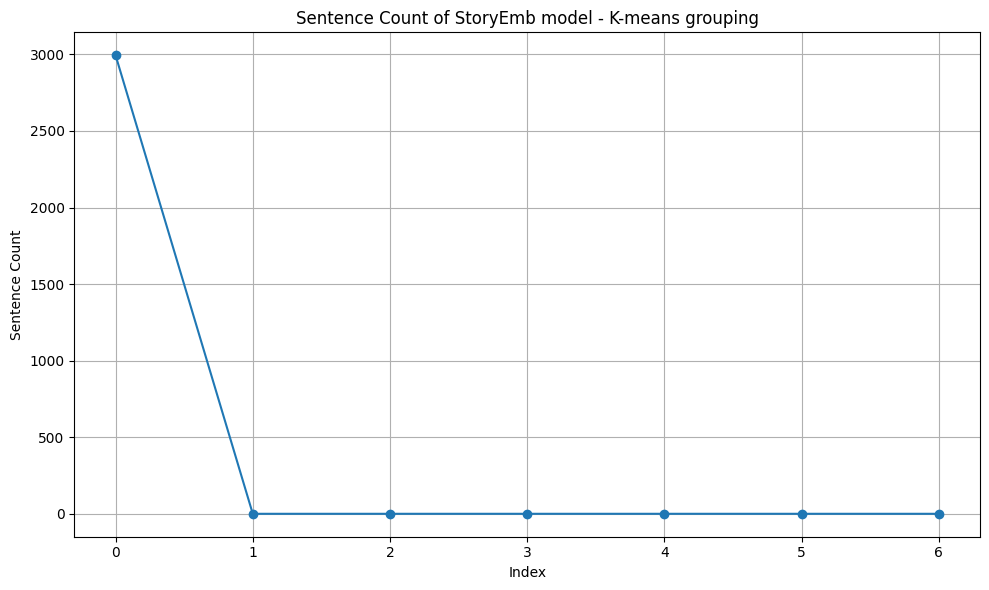

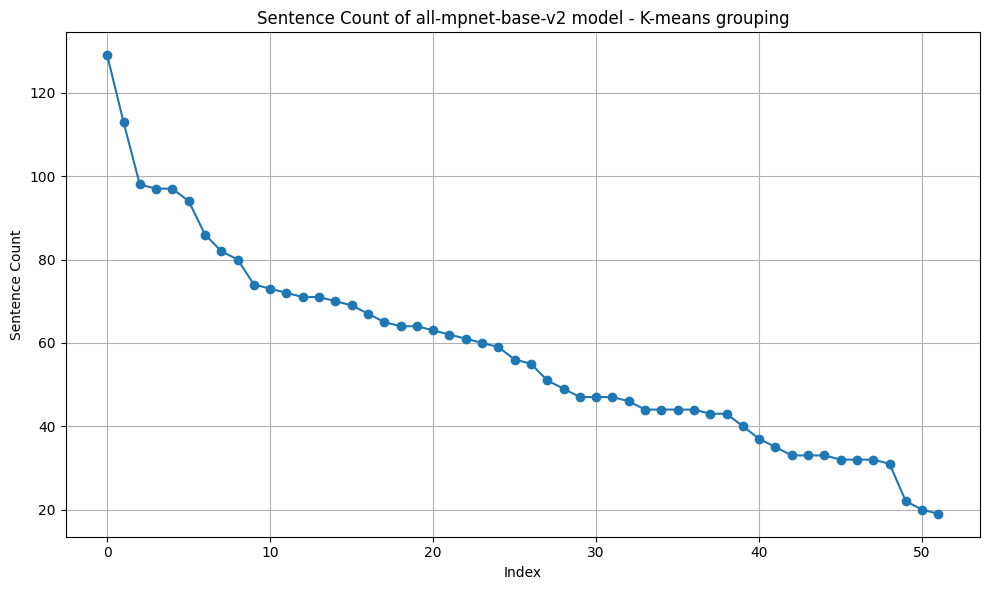

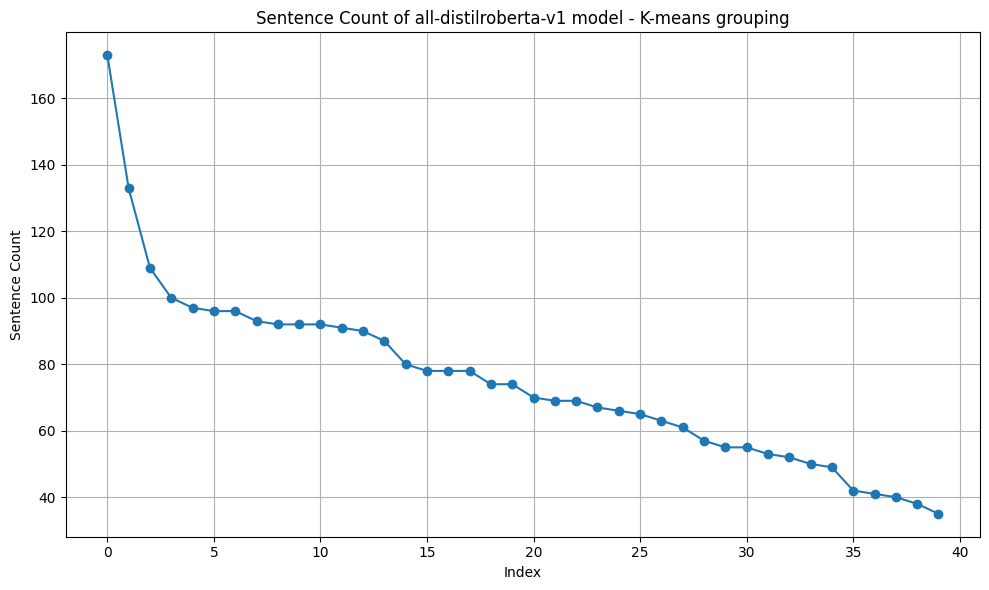

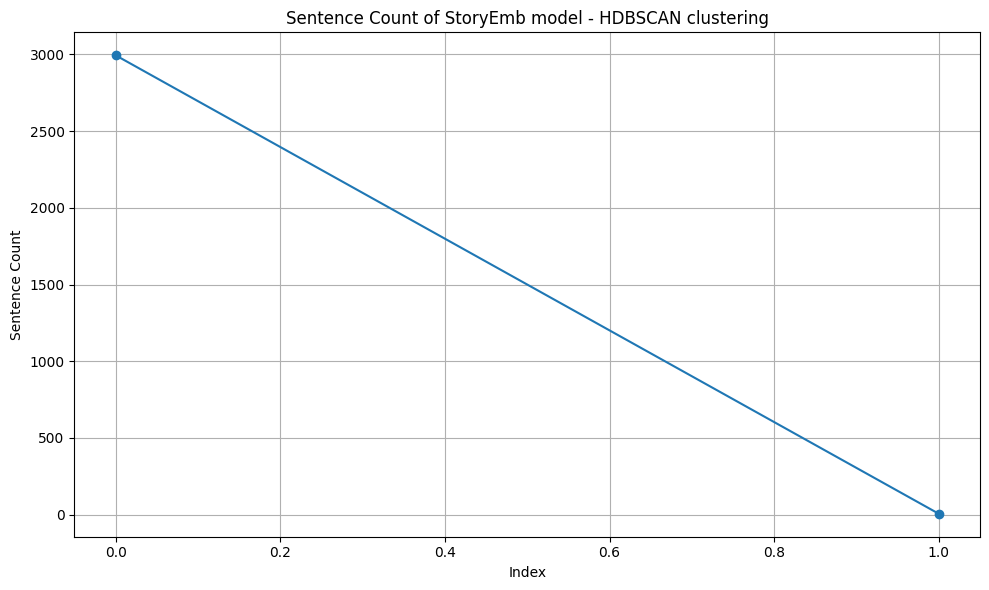

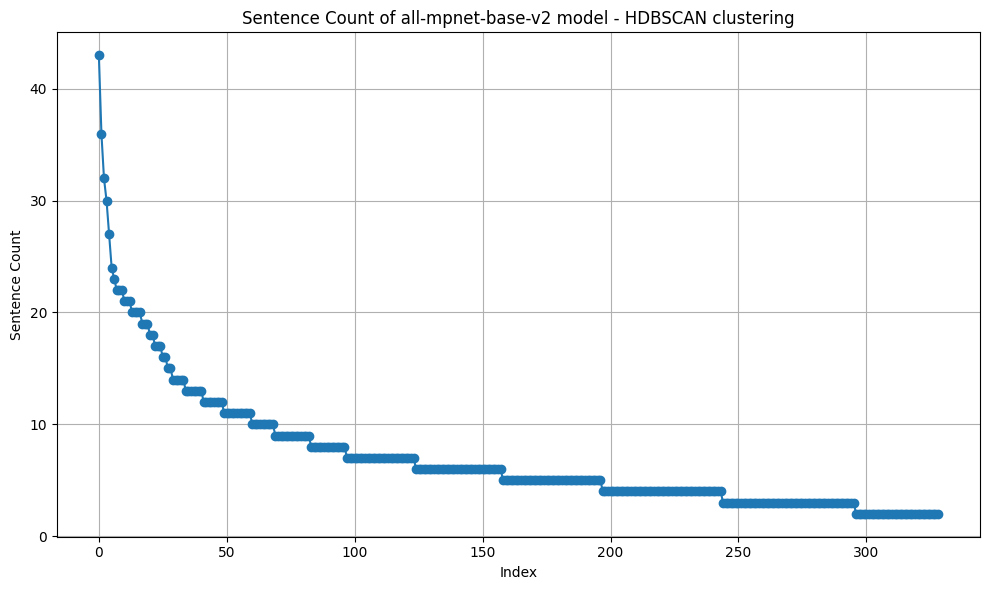

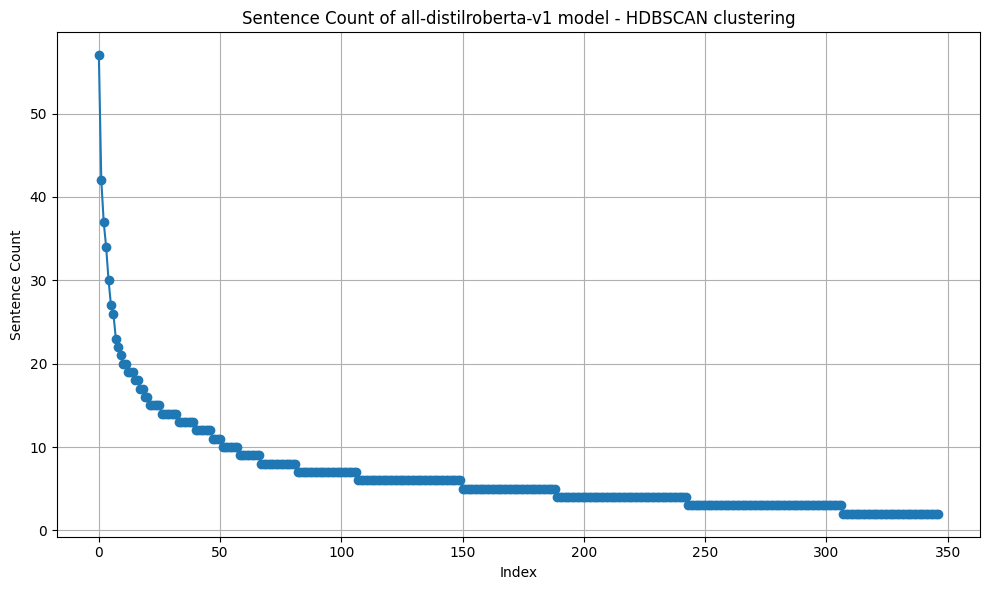

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re

# Create list of vectors and their names
vectors = [
    (vector_sent_kmeans1, "Sentence Count of StoryEmb model - K-means grouping"),
    (vector_sent_kmeans2, "Sentence Count of all-mpnet-base-v2 model - K-means grouping"),
    (vector_sent_kmeans3, "Sentence Count of all-distilroberta-v1 model - K-means grouping"),
    (vector_sent_hdbscan1, "Sentence Count of StoryEmb model - HDBSCAN clustering"),
    (vector_sent_hdbscan2, "Sentence Count of all-mpnet-base-v2 model - HDBSCAN clustering"),
    (vector_sent_hdbscan3, "Sentence Count of all-distilroberta-v1 model - HDBSCAN clustering")
]

# Create the output directory if it doesn't exist
output_dir = '/content/images/'
os.makedirs(output_dir, exist_ok=True)

# Loop through each vector and create its plot
for vector, title in vectors:
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(vector)), vector, marker='o')
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Sentence Count')
    plt.grid(True)
    plt.tight_layout()

    # Create safe filename
    filename = re.sub(r'[^a-zA-Z0-9_\\-]', '_', title) + ".png"
    save_path = os.path.join(output_dir, filename)

    # Save plot
    plt.savefig(save_path)
    plt.show()


## Log Log plot - linear regression
- check for power law distribution


In [33]:
#Linear regression
from scipy.stats import linregress

def linear_regression(counts):
    """Perform linear regression on log-transformed data."""
    # Log transform the data
    x = np.log10(np.arange(1, len(counts)+1))
    y = np.log10(counts)

    # Linear regression
    slope, intercept, r_val, p_val, std_err = linregress(x, y)

    # Regression prediction
    y_pred = slope * x + intercept

    return x, y, slope, intercept, r_val, p_val, y_pred

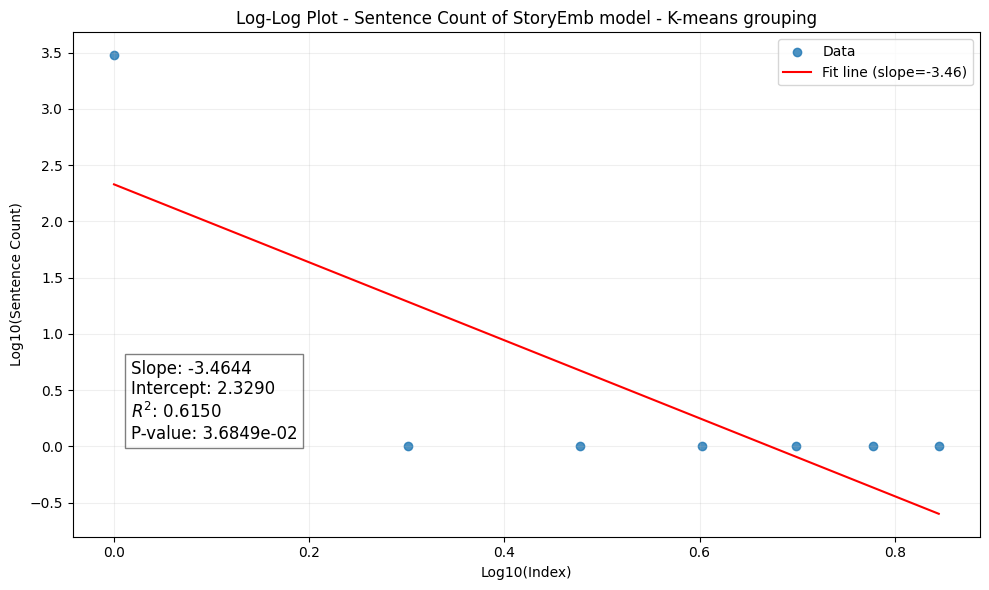


Regression Results for Sentence Count of StoryEmb model - K-means grouping:
   - Slope: -3.4644
   - Intercept: 2.3290
   - R-squared: 0.6150
   - P-value: 3.6849e-02


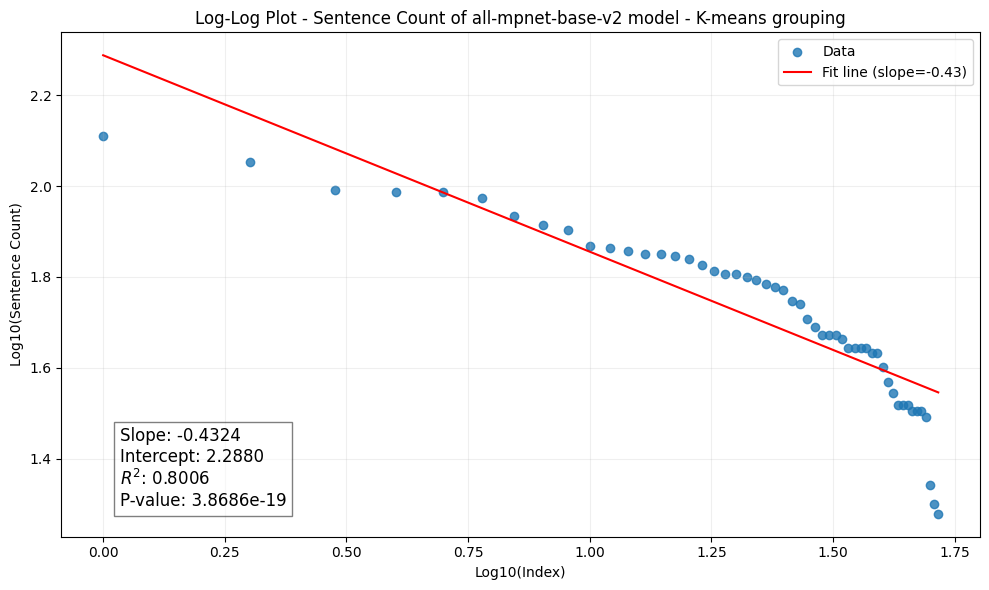


Regression Results for Sentence Count of all-mpnet-base-v2 model - K-means grouping:
   - Slope: -0.4324
   - Intercept: 2.2880
   - R-squared: 0.8006
   - P-value: 3.8686e-19


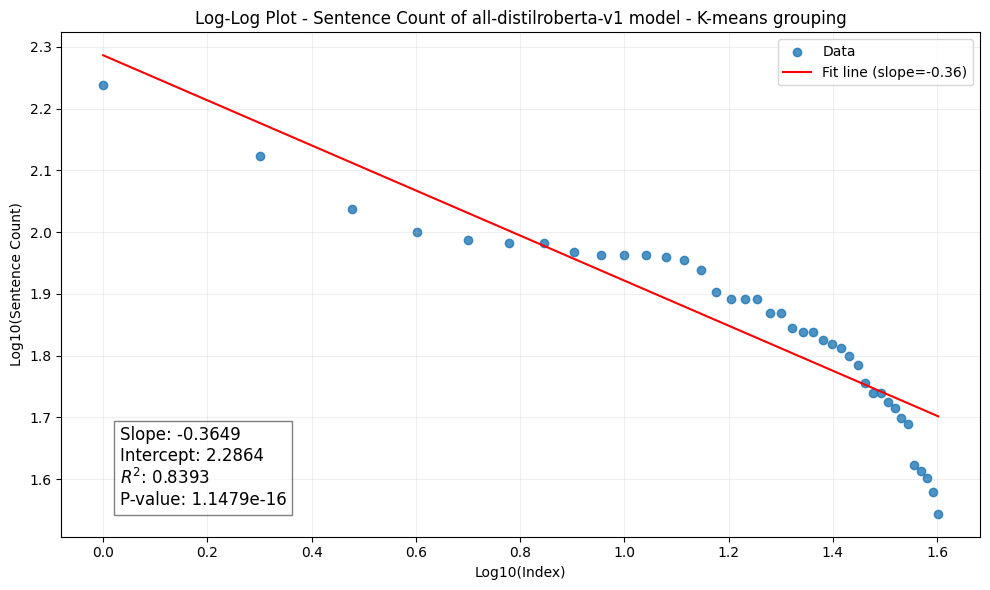


Regression Results for Sentence Count of all-distilroberta-v1 model - K-means grouping:
   - Slope: -0.3649
   - Intercept: 2.2864
   - R-squared: 0.8393
   - P-value: 1.1479e-16


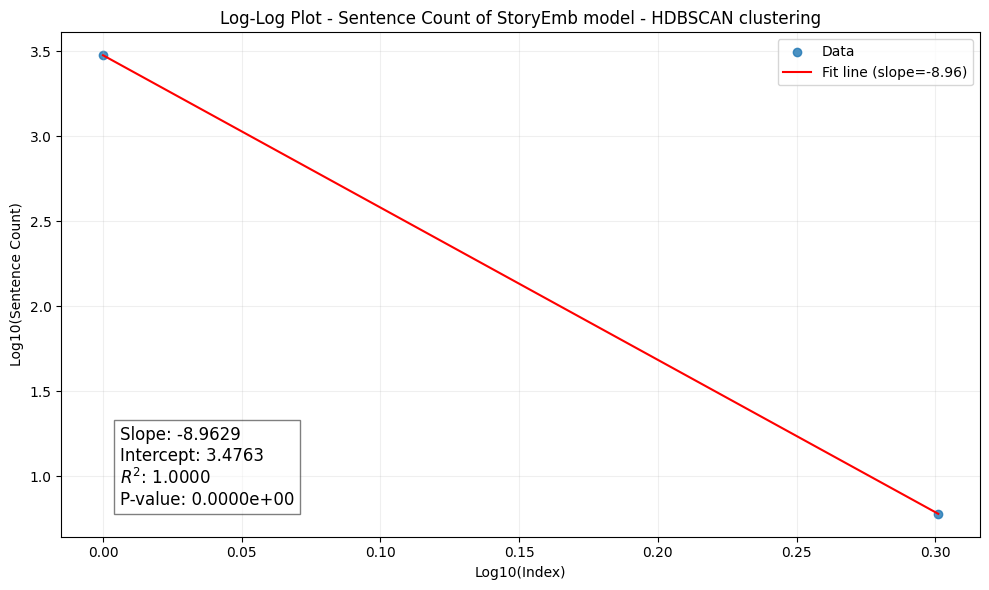


Regression Results for Sentence Count of StoryEmb model - HDBSCAN clustering:
   - Slope: -8.9629
   - Intercept: 3.4763
   - R-squared: 1.0000
   - P-value: 0.0000e+00


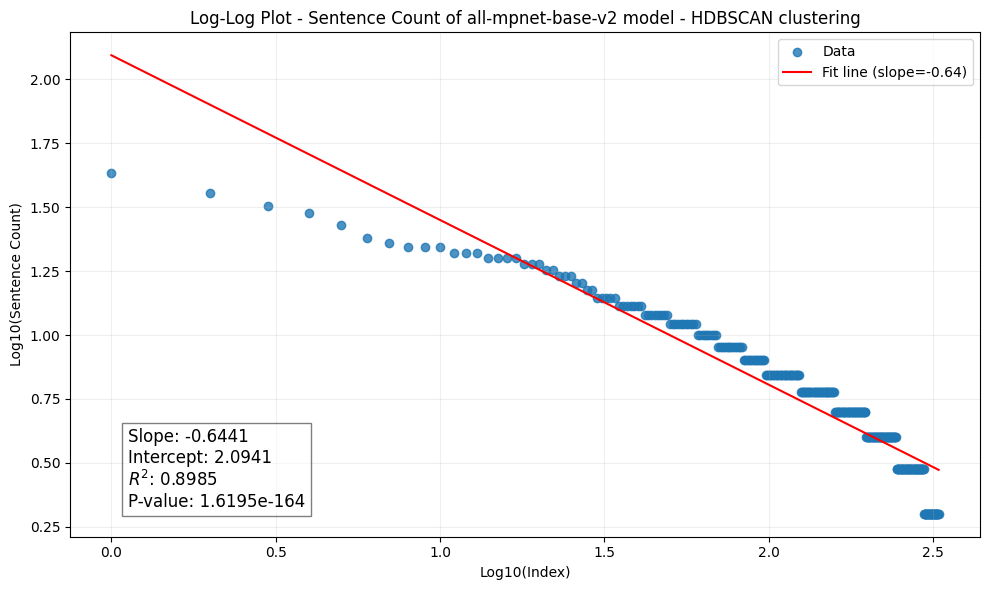


Regression Results for Sentence Count of all-mpnet-base-v2 model - HDBSCAN clustering:
   - Slope: -0.6441
   - Intercept: 2.0941
   - R-squared: 0.8985
   - P-value: 1.6195e-164


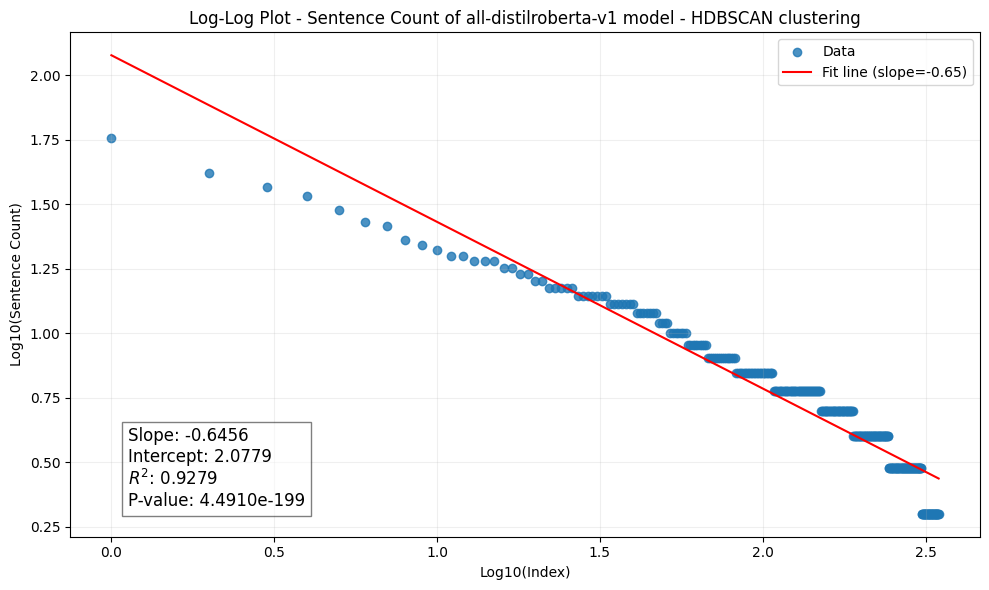


Regression Results for Sentence Count of all-distilroberta-v1 model - HDBSCAN clustering:
   - Slope: -0.6456
   - Intercept: 2.0779
   - R-squared: 0.9279
   - P-value: 4.4910e-199


In [ ]:
# Create the output directory if it doesn't exist
output_dir = '/content/images/'
os.makedirs(output_dir, exist_ok=True)

# Loop through each vector
for vector, title in vectors:
    # Perform linear regression
    x, y, slope, intercept, r_val, p_val, y_pred = linear_regression(vector)

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.8, label='Data')
    plt.plot(x, y_pred, 'r-', label=f'Fit line (slope={slope:.2f})')

    # Customize plot
    plt.title(f"Log-Log Plot - {title}")
    plt.xlabel('Log10(Index)')
    plt.ylabel('Log10(Sentence Count)')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()

    # Add regression statistics box
    text_x = min(x) + (max(x) - min(x)) * 0.02
    text_y = min(y) + (max(y) - min(y)) * 0.02
    plt.text(text_x, text_y,
             f"Slope: {slope:.4f}\nIntercept: {intercept:.4f}\n$R^2$: {r_val**2:.4f}\nP-value: {p_val:.4e}",
             fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()

    # Create a safe filename and save
    filename = re.sub(r'[^a-zA-Z0-9_\\-]', '_', title) + '_loglog.png'
    save_path = os.path.join(output_dir, filename)
    plt.savefig(save_path)
    plt.show()

    # Print regression statistics
    print(f"\nRegression Results for {title}:")
    print(f"   - Slope: {slope:.4f}")
    print(f"   - Intercept: {intercept:.4f}")
    print(f"   - R-squared: {r_val**2:.4f}")
    print(f"   - P-value: {p_val:.4e}")

In [35]:
import shutil
shutil.make_archive('/content/images', 'zip', 'images')
from google.colab import files
files.download('images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# K Means & HDBSCAN Run 2

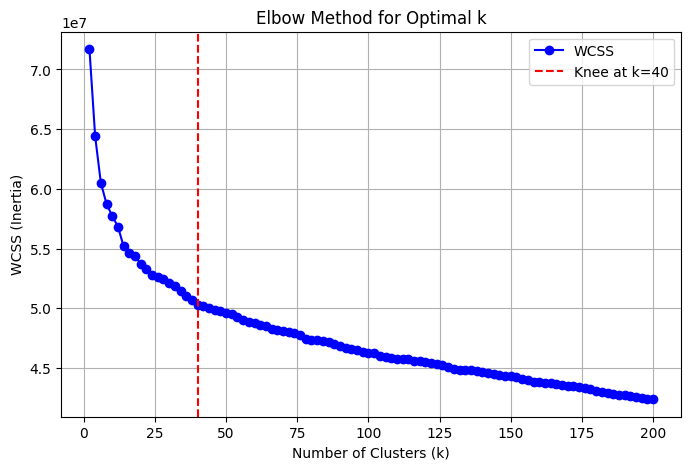

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base

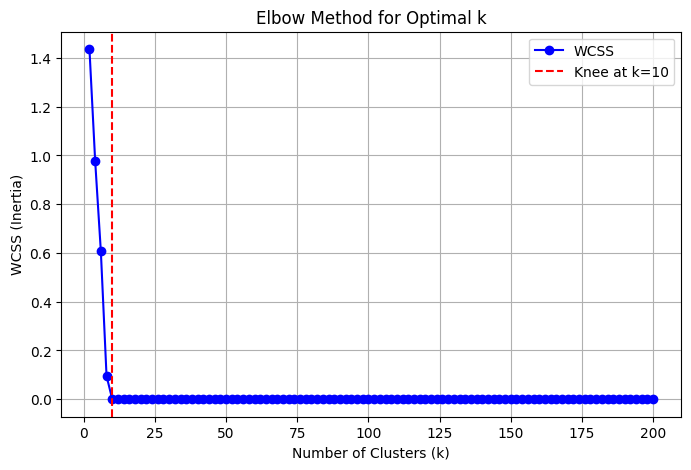

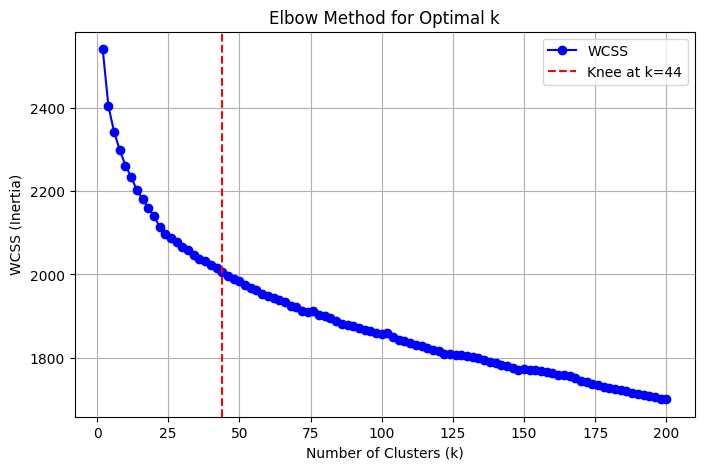

In [13]:
# find optimal number of clusters for each embedding
optimal_k1 = find_optimal_k(embeddings1, k_min=2, k_max=200, k_step=2)
optimal_k2 = find_optimal_k(norm_embedding1, k_min=2, k_max=200, k_step=2)
optimal_k3 = find_optimal_k(norm_embedding2, k_min=2, k_max=200, k_step=2)

In [23]:
# Apply KMeans with the optimal number of clusters
kmeans1 = KMeans(n_clusters=40, random_state=42)
kmeans2 = KMeans(n_clusters=52, random_state=42)
kmeans3 = KMeans(n_clusters=44, random_state=42)

cluster_labels1 = kmeans1.fit_predict(embeddings1)
cluster_labels2 = kmeans2.fit_predict(embeddings2)
cluster_labels3 = kmeans3.fit_predict(norm_embedding3)


In [24]:
from nltk.tokenize import word_tokenize

def count_words_per_cluster(sentences, cluster_labels):
    # group sentences by cluster
    clusters = {}
    for idx, label in enumerate(cluster_labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(sentences[idx])

    # count total words per cluster
    word_counts_per_cluster = {}
    for label, cluster_sentences in clusters.items():
        word_count = 0
        for sentence in cluster_sentences:
            word_count += len(word_tokenize(sentence.lower()))
        word_counts_per_cluster[label] = word_count

    return sorted(word_counts_per_cluster.values(), reverse=True)


def count_sentences_per_cluster(cluster_labels):
    unique, counts = np.unique(cluster_labels, return_counts=True)
    return counts


words_per_cluster1 = count_words_per_cluster(sentences, cluster_labels1)
words_per_cluster2 = count_words_per_cluster(sentences, cluster_labels2)
words_per_cluster3 = count_words_per_cluster(sentences, cluster_labels3)

sentences_per_cluster1 = count_sentences_per_cluster(cluster_labels1)
sentences_per_cluster2 = count_sentences_per_cluster(cluster_labels2)
sentences_per_cluster3 = count_sentences_per_cluster(cluster_labels3)

vector_sent_kmeans1 = np.array(sorted(sentences_per_cluster1, reverse=True))
vector_sent_kmeans2 = np.array(sorted(sentences_per_cluster2, reverse=True))
vector_sent_kmeans3 = np.array(sorted(sentences_per_cluster3, reverse=True))


print("Embedding 1:")
print("\nSentence counts per cluster in Kmeans1:", vector_sent_kmeans1[:10])
print("\nWord counts per cluster in Kmeans1:", words_per_cluster1[:5])
print ("-------------------")
print("Embedding 2:")
print("\nSentence counts per cluster in Kmeans2:", vector_sent_kmeans2[:5])
print("\nWord counts per cluster in Kmeans2:", words_per_cluster2[:5])
print ("-------------------")
print("Embedding 3:")
print("\nSentence counts per cluster in Kmeans3:", vector_sent_kmeans3[:5])
print("\nWord counts per cluster in Kmeans3:", words_per_cluster3[:5])


Embedding 1:

Sentence counts per cluster in Kmeans1: [197 193 172 157 138 133 128 101 100  86]

Word counts per cluster in Kmeans1: [7926, 4735, 3773, 3460, 3121]
-------------------
Embedding 2:

Sentence counts per cluster in Kmeans2: [195 148 117  96  90]

Word counts per cluster in Kmeans2: [6682, 3041, 2212, 2209, 2018]
-------------------
Embedding 3:

Sentence counts per cluster in Kmeans3: [172 147 129 124 116]

Word counts per cluster in Kmeans3: [3696, 3535, 3362, 3099, 2712]


In [25]:
embeddings1_study = tune_umap(embeddings1)
print("embeddings1 best score :", embeddings1_study.best_value)
print("embeddings1 best params:", embeddings1_study.best_params)

[I 2025-05-13 08:04:02,270] A new study created in memory with name: no-name-8bece232-14c4-4a69-9b98-2664df7ec417
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-13 08:04:38,769] Trial 0 finished with value: 0.2595328688621521 and parameters: {'n_components': 30, 'n_neighbors': 15}. Be

embeddings1 best score : 0.30930230021476746
embeddings1 best params: {'n_components': 15, 'n_neighbors': 10}


In [28]:
#generating clusters
hdbscan_group1 = hdbscan_clusters(
    embeddings1,
    n_neighbors=10,
    n_components=15,
    random_state=42
)


# cluster labels
labels_hdbscan1 = hdbscan_group1.labels_

# count unique clusters (excluding noise points labeled as -1)
num_clusters_group1 = len(set(labels_hdbscan1)) - (1 if -1 in labels_hdbscan1 else 0)


print(f"Number of clusters in Group 1: {num_clusters_group1}")

sentence_counts_hdbscan1 = count_sentences_per_hdbscan_cluster(labels_hdbscan1)


word_counts_hdbscan1 = count_words_per_hdbscan_cluster(sentences, labels_hdbscan1)

vector_sent_hdbscan1 = np.array(sorted(sentence_counts_hdbscan1, reverse=True))

print("\nEmbedding 1")
print("Sentence counts per cluster in HDBSCAN Group 1:", vector_sent_hdbscan1[:5])
print("Unique word counts per cluster in HDBSCAN Group 1:", word_counts_hdbscan1[:5])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Number of clusters in Group 1: 360

Embedding 1
Sentence counts per cluster in HDBSCAN Group 1: [63 57 57 46 31]
Unique word counts per cluster in HDBSCAN Group 1: [2251, 1927, 1193, 1023, 899]


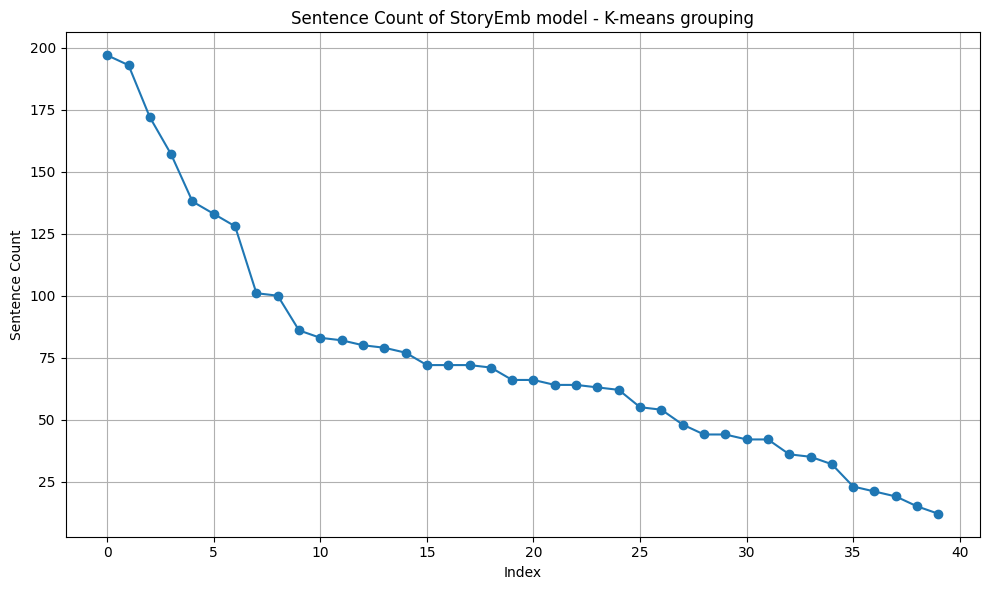

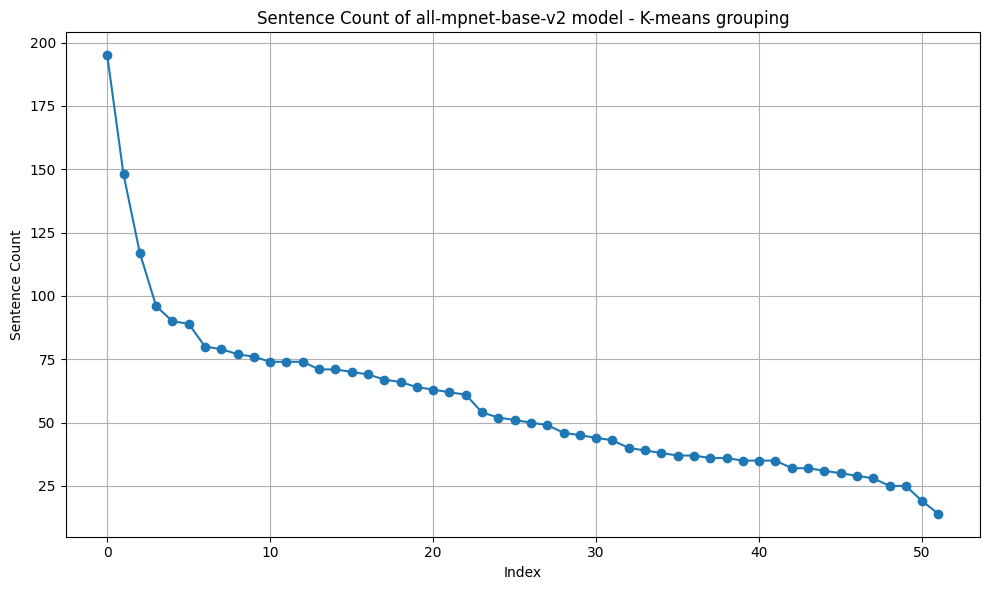

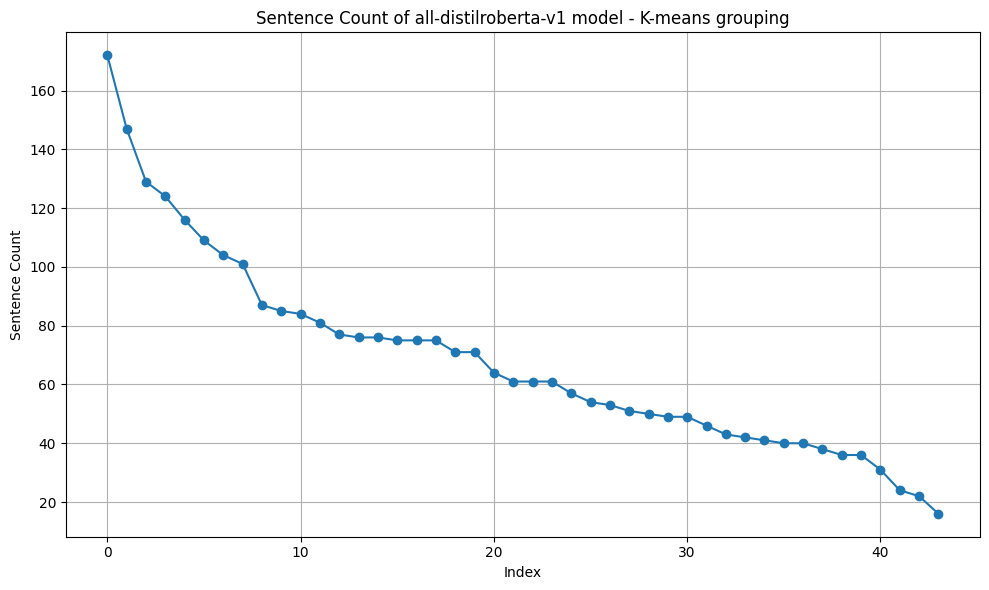

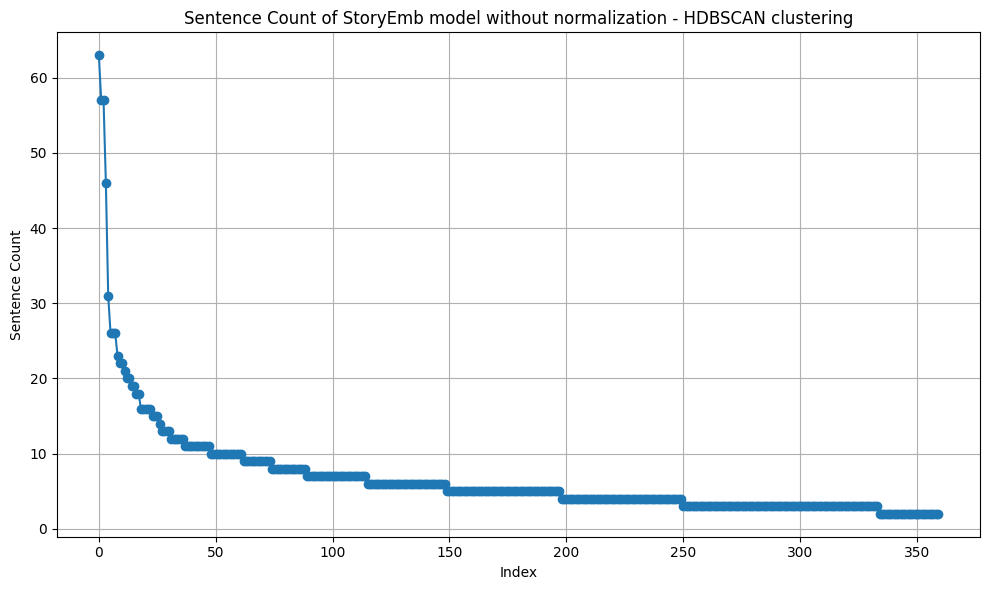

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re

# Create the output directory if it doesn't exist
output_dir = '/content/images/'
os.makedirs(output_dir, exist_ok=True)


vectors_kmeans_nonnorm = [
    (vector_sent_kmeans1, "Sentence Count of StoryEmb model - K-means grouping"),
    (vector_sent_kmeans2, "Sentence Count of all-mpnet-base-v2 model - K-means grouping"),
    (vector_sent_kmeans3, "Sentence Count of all-distilroberta-v1 model - K-means grouping"),
    (vector_sent_hdbscan1, "Sentence Count of StoryEmb model without normalization - HDBSCAN clustering"),
]

# Loop through each vector and create its plot
for vector, title in vectors_kmeans_nonnorm:
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(vector)), vector, marker='o')
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Sentence Count')
    plt.grid(True)
    plt.tight_layout()

    # Create safe filename
    filename = re.sub(r'[^a-zA-Z0-9_\\-]', '_', title) + ".png"
    save_path = os.path.join(output_dir, filename)
    plt.savefig(save_path)


    plt.show()

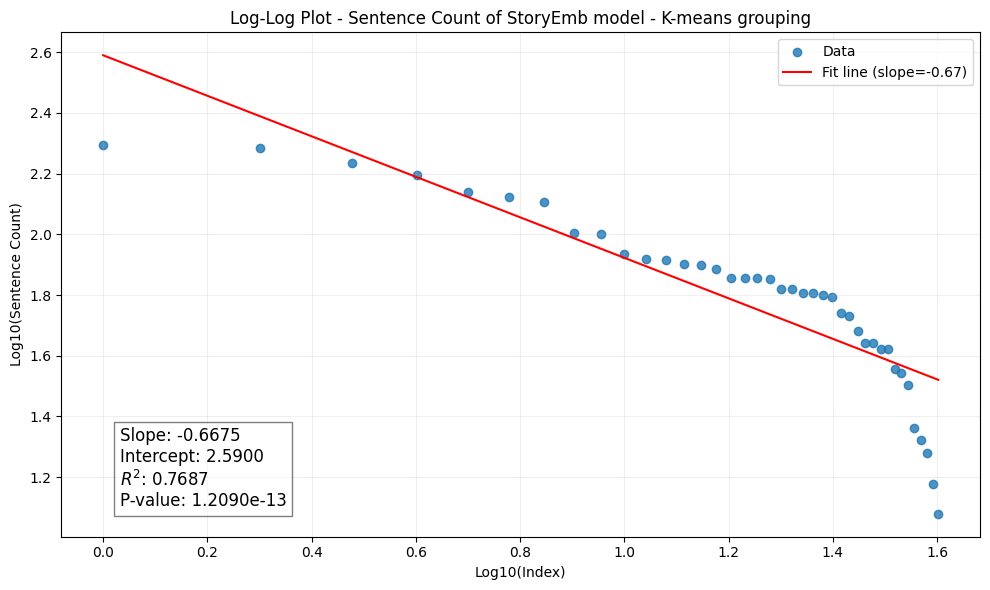


Regression Results for Sentence Count of StoryEmb model - K-means grouping:
   - Slope: -0.6675
   - Intercept: 2.5900
   - R-squared: 0.7687
   - P-value: 1.2090e-13


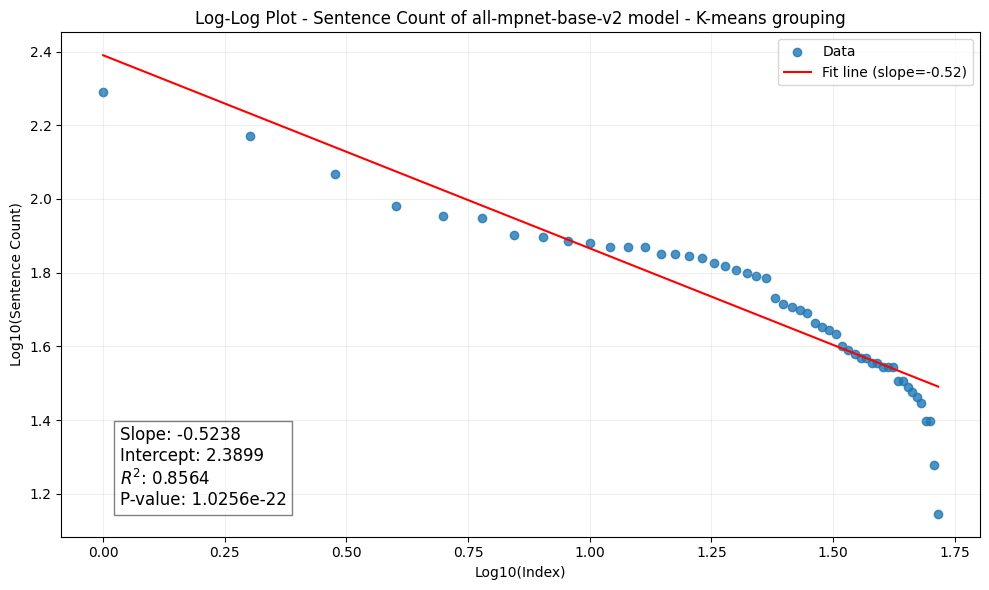


Regression Results for Sentence Count of all-mpnet-base-v2 model - K-means grouping:
   - Slope: -0.5238
   - Intercept: 2.3899
   - R-squared: 0.8564
   - P-value: 1.0256e-22


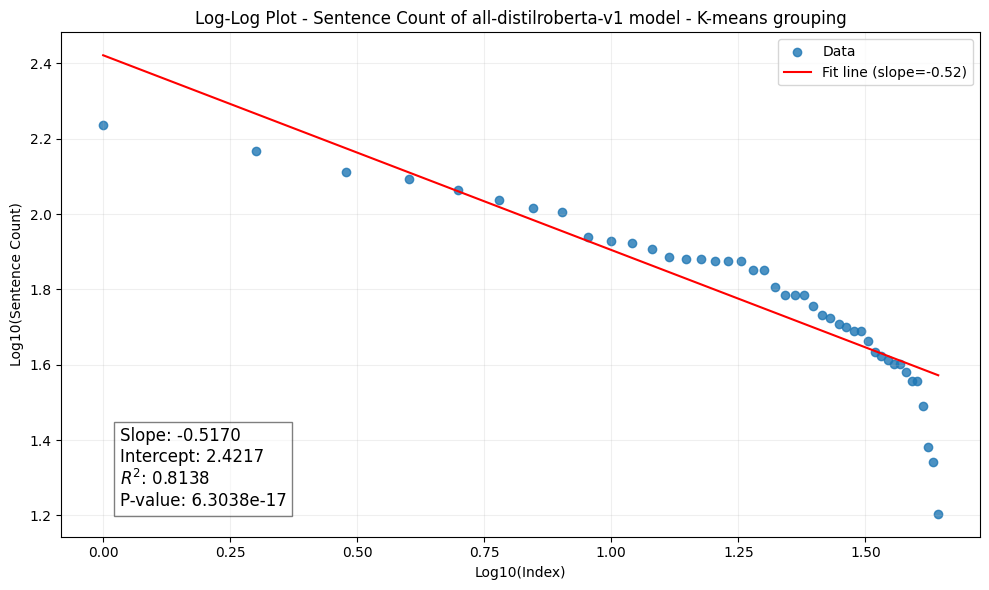


Regression Results for Sentence Count of all-distilroberta-v1 model - K-means grouping:
   - Slope: -0.5170
   - Intercept: 2.4217
   - R-squared: 0.8138
   - P-value: 6.3038e-17


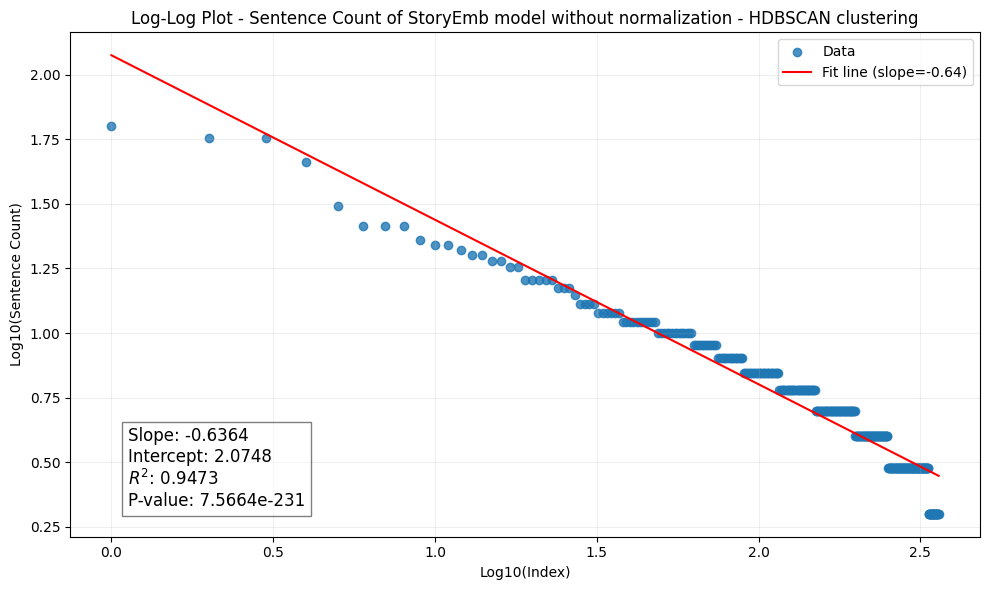


Regression Results for Sentence Count of StoryEmb model without normalization - HDBSCAN clustering:
   - Slope: -0.6364
   - Intercept: 2.0748
   - R-squared: 0.9473
   - P-value: 7.5664e-231


In [34]:
from scipy.stats import linregress
for vector, title in vectors_kmeans_nonnorm:
    # Perform linear regression
    x, y, slope, intercept, r_val, p_val, y_pred = linear_regression(vector)

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.8, label='Data')
    plt.plot(x, y_pred, 'r-', label=f'Fit line (slope={slope:.2f})')

    # Customize plot
    plt.title(f"Log-Log Plot - {title}")
    plt.xlabel('Log10(Index)')
    plt.ylabel('Log10(Sentence Count)')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()

    # Add regression statistics box
    text_x = min(x) + (max(x) - min(x)) * 0.02
    text_y = min(y) + (max(y) - min(y)) * 0.02
    plt.text(text_x, text_y,
             f"Slope: {slope:.4f}\nIntercept: {intercept:.4f}\n$R^2$: {r_val**2:.4f}\nP-value: {p_val:.4e}",
             fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()

    # Create a safe filename and save
    filename = re.sub(r'[^a-zA-Z0-9_\\-]', '_', title) + '_loglog.png'
    save_path = os.path.join(output_dir, filename)
    plt.savefig(save_path)
    plt.show()

    # Print regression statistics
    print(f"\nRegression Results for {title}:")
    print(f"   - Slope: {slope:.4f}")
    print(f"   - Intercept: {intercept:.4f}")
    print(f"   - R-squared: {r_val**2:.4f}")
    print(f"   - P-value: {p_val:.4e}")